<a href="https://colab.research.google.com/github/movses111/coin-classification-armenian-coins/blob/main/01_data_collection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Ներածություն


# Հայկական մետաղադրամների դասակարգում մեքենայական ուսուցմամբ

Նախագիծ՝ նախագծային աշխատանք  
Թեմա՝ Պատկերների հիման վրա հայկական մետաղադրամների ավտոմատ դասակարգման համակարգի մշակում  
Օբյեկտներ՝ 10, 20, 100 դրամ  


## Փուլ 2՝ Տվյալների հավաքագրում

In [22]:
import os

base_path = "/content/data/raw"

classes = ["10dram", "20dram", "100dram"]

for cls in classes:
    os.makedirs(os.path.join(base_path, cls), exist_ok=True)

print("Folders created:", classes)


Folders created: ['10dram', '20dram', '100dram']


In [23]:
import os

base_path = "/content/data/raw"

for cls in os.listdir(base_path):
    cls_path = os.path.join(base_path, cls)
    print(f"{cls}: {len(os.listdir(cls_path))} images")


100dram: 13 images
10dram: 7 images
20dram: 8 images


##Փուլ 3՝ Տվյալների մաքրում և նախապատրաստում

(np.float64(-0.5), np.float64(413.5), np.float64(413.5), np.float64(-0.5))

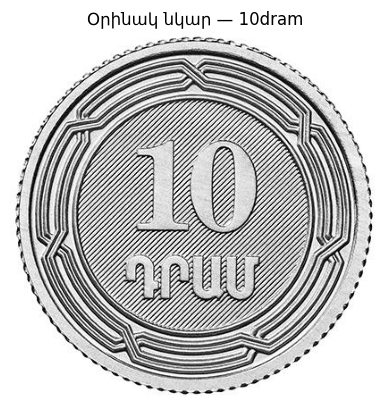

In [24]:
import os
import cv2
import matplotlib.pyplot as plt

base_path = "/content/data/raw"
classes = ["10dram", "20dram", "100dram"]

# կարդում ենք առաջին նկարը ստուգման համար
sample_class = classes[0]
sample_img_name = os.listdir(os.path.join(base_path, sample_class))[0]
sample_img_path = os.path.join(base_path, sample_class, sample_img_name)

img = cv2.imread(sample_img_path)
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

plt.imshow(img_rgb)
plt.title(f"Օրինակ նկար — {sample_class}")
plt.axis("off")


In [25]:
import numpy as np

processed_path = "/content/data/processed"
os.makedirs(processed_path, exist_ok=True)

for cls in classes:
    os.makedirs(os.path.join(processed_path, cls), exist_ok=True)

IMG_SIZE = 128

for cls in classes:
    src_folder = os.path.join(base_path, cls)
    dst_folder = os.path.join(processed_path, cls)

    for fname in os.listdir(src_folder):
        if fname.lower().endswith((".jpg", ".png", ".jpeg")):
            img = cv2.imread(os.path.join(src_folder, fname))
            if img is None:
                continue

            img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
            cv2.imwrite(os.path.join(dst_folder, fname), img)

print("✔ Բոլոր նկարները վերամշակվել են")


✔ Բոլոր նկարները վերամշակվել են


In [26]:
normalized_path = "/content/data/normalized"
os.makedirs(normalized_path, exist_ok=True)

for cls in classes:
    os.makedirs(os.path.join(normalized_path, cls), exist_ok=True)

for cls in classes:
    src_folder = os.path.join(processed_path, cls)
    dst_folder = os.path.join(normalized_path, cls)

    for fname in os.listdir(src_folder):
        img = cv2.imread(os.path.join(src_folder, fname))
        if img is None:
            continue

        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        norm = gray / 255.0   # normalization 0-1

        # պահում ենք float → uint8
        norm_uint8 = (norm * 255).astype("uint8")
        cv2.imwrite(os.path.join(dst_folder, fname), norm_uint8)

print("✔ Grayscale + Normalization done")


✔ Grayscale + Normalization done


In [27]:
for cls in classes:
    count = len(os.listdir(os.path.join(normalized_path, cls)))
    print(f"{cls}: {count} images after preprocessing")


10dram: 6 images after preprocessing
20dram: 7 images after preprocessing
100dram: 12 images after preprocessing


##Փուլ 4՝ Տվյալների վերլուծություն

In [28]:
import os
import cv2
import numpy as np
from skimage.feature import hog
from sklearn.model_selection import train_test_split


In [29]:
data_path = "/content/data/normalized"
classes = ["10dram", "20dram", "100dram"]

X = []
y = []

for label, cls in enumerate(classes):
    folder = os.path.join(data_path, cls)

    for fname in os.listdir(folder):
        if fname.lower().endswith((".jpg", ".png", ".jpeg")):
            img_path = os.path.join(folder, fname)
            img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
            if img is None:
                continue

            X.append(img)
            y.append(label)

X = np.array(X)
y = np.array(y)

print("Dataset shape:", X.shape)
print("Labels shape:", y.shape)


Dataset shape: (25, 128, 128)
Labels shape: (25,)


In [30]:
def extract_hog_features(images):
    features = []
    for img in images:
        hog_feat = hog(
            img,
            orientations=9,
            pixels_per_cell=(8, 8),
            cells_per_block=(2, 2),
            block_norm='L2-Hys'
        )
        features.append(hog_feat)
    return np.array(features)

X_features = extract_hog_features(X)

print("HOG feature vector shape:", X_features.shape)


HOG feature vector shape: (25, 8100)


In [31]:
X_train, X_test, y_train, y_test = train_test_split(
    X_features, y,
    test_size=0.25,
    random_state=42,
    stratify=y
)

print("Train:", X_train.shape, "Test:", X_test.shape)


Train: (18, 8100) Test: (7, 8100)


In [32]:
np.save("/content/data/X_train.npy", X_train)
np.save("/content/data/X_test.npy", X_test)
np.save("/content/data/y_train.npy", y_train)
np.save("/content/data/y_test.npy", y_test)

print("✔ Dataset saved for modeling")


✔ Dataset saved for modeling


##Փուլ 5՝ Մոդելավորում

In [33]:
import numpy as np
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns


In [34]:
X_train = np.load("/content/data/X_train.npy")
X_test  = np.load("/content/data/X_test.npy")
y_train = np.load("/content/data/y_train.npy")
y_test  = np.load("/content/data/y_test.npy")

print(X_train.shape, X_test.shape)


(18, 8100) (7, 8100)


In [35]:
svm_model = SVC(kernel="rbf", C=10, gamma="scale")
svm_model.fit(X_train, y_train)

y_pred_svm = svm_model.predict(X_test)

print("=== SVM Results ===")
print("Accuracy:", accuracy_score(y_test, y_pred_svm))
print(classification_report(y_test, y_pred_svm))


=== SVM Results ===
Accuracy: 0.7142857142857143
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         2
           1       1.00      1.00      1.00         2
           2       0.60      1.00      0.75         3

    accuracy                           0.71         7
   macro avg       0.53      0.67      0.58         7
weighted avg       0.54      0.71      0.61         7



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [36]:
rf_model = RandomForestClassifier(
    n_estimators=200,
    random_state=42
)
rf_model.fit(X_train, y_train)

y_pred_rf = rf_model.predict(X_test)

print("=== Random Forest Results ===")
print("Accuracy:", accuracy_score(y_test, y_pred_rf))
print(classification_report(y_test, y_pred_rf))


=== Random Forest Results ===
Accuracy: 0.7142857142857143
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         2
           1       1.00      1.00      1.00         2
           2       0.60      1.00      0.75         3

    accuracy                           0.71         7
   macro avg       0.53      0.67      0.58         7
weighted avg       0.54      0.71      0.61         7



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [38]:
!pip install xgboost


In [39]:
from xgboost import XGBClassifier

xgb_model = XGBClassifier(
    n_estimators=300,
    max_depth=6,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    objective="multi:softmax",
    num_class=3,
    eval_metric="mlogloss"
)

xgb_model.fit(X_train, y_train)

y_pred_xgb = xgb_model.predict(X_test)

print("=== XGBoost Results ===")
print("Accuracy:", accuracy_score(y_test, y_pred_xgb))
print(classification_report(y_test, y_pred_xgb))


=== XGBoost Results ===
Accuracy: 0.7142857142857143
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         2
           1       1.00      1.00      1.00         2
           2       0.60      1.00      0.75         3

    accuracy                           0.71         7
   macro avg       0.53      0.67      0.58         7
weighted avg       0.54      0.71      0.61         7



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


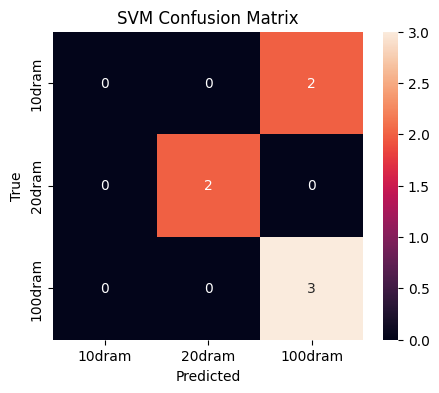

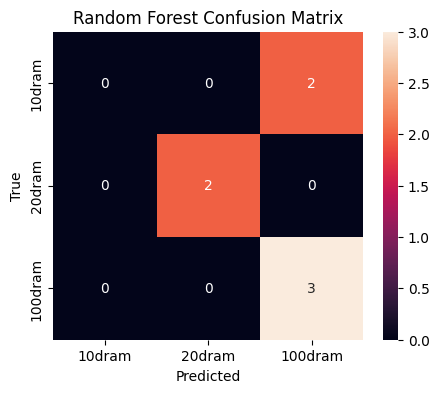

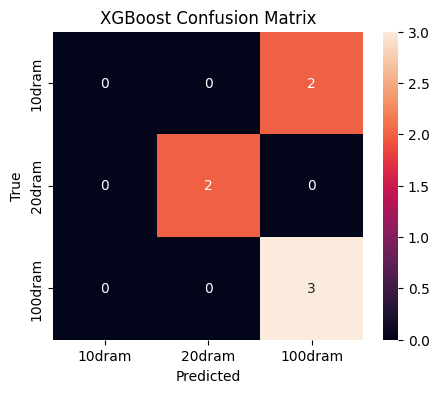

In [40]:
def plot_confusion(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(5,4))
    sns.heatmap(cm, annot=True, fmt="d",
                xticklabels=["10dram","20dram","100dram"],
                yticklabels=["10dram","20dram","100dram"])
    plt.title(title)
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.show()

plot_confusion(y_test, y_pred_svm, "SVM Confusion Matrix")
plot_confusion(y_test, y_pred_rf, "Random Forest Confusion Matrix")
plot_confusion(y_test, y_pred_xgb, "XGBoost Confusion Matrix")


In [41]:
results = {
    "Model": ["SVM", "Random Forest", "XGBoost"],
    "Accuracy": [
        accuracy_score(y_test, y_pred_svm),
        accuracy_score(y_test, y_pred_rf),
        accuracy_score(y_test, y_pred_xgb)
    ]
}

for m, a in zip(results["Model"], results["Accuracy"]):
    print(f"{m}: {a:.3f}")


SVM: 0.714
Random Forest: 0.714
XGBoost: 0.714
